Note: We conducted experimentation with various vectorization techniques and classification models on our sample data to find out the most suitable methods for our data. It turned out HashingTF and LinearSVC yield better performance for our dataset.

In [1]:
import sparknlp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

In [2]:
#create Spark session
spark = SparkSession.builder.appName('YelpML').getOrCreate()

#change configuration settings on Spark 
conf = spark.sparkContext._conf.setAll([('spark.executor.memory', '5g'), ('spark.app.name', 'Spark Upadated Conf'), ('spark.executor.cores', '4'),('spark.cores.max', '4'), ('spark.driver.memory', '8g')])

#print spark configuration settings
spark.sparkContext.getConf().getAll()

[('spark.stage.maxConsecutiveAttempts', '10'),
 ('spark.dynamicAllocation.minExecutors', '1'),
 ('spark.eventLog.enabled', 'true'),
 ('spark.submit.pyFiles',
  '/root/.ivy2/jars/com.johnsnowlabs.nlp_spark-nlp_2.12-4.4.0.jar,/root/.ivy2/jars/graphframes_graphframes-0.8.2-spark3.1-s_2.12.jar,/root/.ivy2/jars/com.typesafe_config-1.4.2.jar,/root/.ivy2/jars/org.rocksdb_rocksdbjni-6.29.5.jar,/root/.ivy2/jars/com.amazonaws_aws-java-sdk-bundle-1.11.828.jar,/root/.ivy2/jars/com.github.universal-automata_liblevenshtein-3.0.0.jar,/root/.ivy2/jars/com.google.cloud_google-cloud-storage-2.16.0.jar,/root/.ivy2/jars/com.navigamez_greex-1.0.jar,/root/.ivy2/jars/com.johnsnowlabs.nlp_tensorflow-cpu_2.12-0.4.4.jar,/root/.ivy2/jars/it.unimi.dsi_fastutil-7.0.12.jar,/root/.ivy2/jars/org.projectlombok_lombok-1.16.8.jar,/root/.ivy2/jars/com.google.guava_guava-31.1-jre.jar,/root/.ivy2/jars/com.google.guava_failureaccess-1.0.1.jar,/root/.ivy2/jars/com.google.guava_listenablefuture-9999.0-empty-to-avoid-conflict-

In [3]:
# Import Data
dataDir = "gs://msca-bdp-student-gcs/group2/yelp-datasample2"
business = spark.read.json(dataDir + "/sample_business")
review = spark.read.json(dataDir + "/sample_review")
tip = spark.read.json(dataDir + "/sample_tip")

23/08/16 17:33:04 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


## Overview

### Join review df and business df to find the category information for all kinds of businesses

In [4]:
review.show(5)

+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|         business_id|cool|               date|funny|           review_id|stars|                text|useful|             user_id|
+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|arKiXax3ScSM_z3O-...|   0|2010-10-17 01:50:46|    0|zCNdcNrkIKefTPbak...|  5.0|Great Italian foo...|     0|bz2FrqfKrVmS7WwC-...|
|aeFXIzYpWjSdtq5w8...|   3|2013-06-29 13:42:57|    0|aweHR8S6QAEuV4hoH...|  3.0|I have heard many...|     4|CAU7F-vDqbQZ67BBY...|
|rAytSQU5RQHvXe1Wl...|   1|2021-02-03 21:32:58|    0|CefnkUvmbiDsexuxz...|  5.0|I wish this locat...|     2|BHcPaG4X220bQsqOR...|
|uFLqtC7Yq03dDrxU0...|   2|2013-02-09 13:23:26|    2|geSJqq4MUPos2l8ZI...|  4.0|Why I like Smooth...|     7|DAeC-Y66n-jNMJJw4...|
|3u1cP7H4g325tkhNE...|   0|2021-01-02 17:01:16|    0|P0gEHckZurgPi7_7f...|  5.0|I rarely g

In [5]:
review.count()

70241

In [4]:
review = review.select('business_id', 'text', 'stars')

In [7]:
review.show(5)

+--------------------+--------------------+-----+
|         business_id|                text|stars|
+--------------------+--------------------+-----+
|arKiXax3ScSM_z3O-...|Great Italian foo...|  5.0|
|aeFXIzYpWjSdtq5w8...|I have heard many...|  3.0|
|rAytSQU5RQHvXe1Wl...|I wish this locat...|  5.0|
|uFLqtC7Yq03dDrxU0...|Why I like Smooth...|  4.0|
|3u1cP7H4g325tkhNE...|I rarely go to a ...|  5.0|
+--------------------+--------------------+-----+
only showing top 5 rows



In [8]:
business.show(5)

+-------------------+--------------------+--------------------+--------------------+-------------------+--------------------+-------+-------------+--------------+--------------------+-----------+------------+-----+-----+
|            address|          attributes|         business_id|          categories|               city|               hours|is_open|     latitude|     longitude|                name|postal_code|review_count|stars|state|
+-------------------+--------------------+--------------------+--------------------+-------------------+--------------------+-------+-------------+--------------+--------------------+-----------+------------+-----+-----+
|      2141 Caton St|{null, null, null...|FR5xx5YEzxAnoMdqG...|Fitness & Instruc...|        New Orleans|{0:0-0:0, 0:0-0:0...|      1|   29.9991154|   -90.0607732|     Anytime Fitness|      70122|           6|  3.0|   LA|
|5413 Neshaminy Blvd|{null, null, u'no...|p184f-Zvf4ToPwLba...|Chinese, Restaura...|           Bensalem|{11:30-23:0,

In [5]:
business = business.select('business_id', 'categories', 'stars')

In [10]:
business.show(5)

+--------------------+--------------------+-----+
|         business_id|          categories|stars|
+--------------------+--------------------+-----+
|FR5xx5YEzxAnoMdqG...|Fitness & Instruc...|  3.0|
|p184f-Zvf4ToPwLba...|Chinese, Restaura...|  3.5|
|cl5NjtALgaX7E-WL2...|Food, Wholesalers...|  4.5|
|Q-a-DzqRufrPL6EcU...|Beer, Wine & Spir...|  3.5|
|isbeaPln-E0DdffLR...|Specialty Food, M...|  4.0|
+--------------------+--------------------+-----+
only showing top 5 rows



In [6]:
from pyspark.sql.functions import explode, split
business = business.withColumn('categories_split', explode(split('categories', ', ')))

In [ ]:
business.show()

### Choose the reviews of restaurant category for furthur analysis

In [7]:
from pyspark.sql.functions import col
business = business.where(col('categories_split') == 'Restaurants').select('business_id', 'categories_split')

In [8]:
df = review.join(business, on = 'business_id', how = 'inner')

In [ ]:
df.show(5)

In [ ]:
df.printSchema()

In [ ]:
df.count()

In [9]:
df = df.repartition(16)

### Data Exploration

In [ ]:
df1 = df.groupBy('stars').count().orderBy('stars', ascending = [1])

In [ ]:
df1.show()

In [ ]:
pdf1 = df1.toPandas()

In [ ]:
pdf1.plot(kind = 'bar', x = 'stars', y = 'count', rot = 360)

We have observed a trend where 5-star reviews receive the highest level of popularity. Additionally, we've noticed that 1-star reviews are more frequent compared to reviews with 2 or 3 stars. It can be assumed that customers are more inclined to go through the effort of writing a review when they are either extremely satisfied or extremely dissatisfied.

The stars are then relabelled so that any reviews with 4 stars or above will be positive, anything else is deemed to be negative. This benchmark is based on a general consensus about Yelp reviews where people tend to overrate restaurants/businesses unless they feel strongly negatively about the place. 

In [10]:
from pyspark.sql.functions import when
df = df.withColumn("label", when(df.stars >= 4, 1).otherwise(0))

In [ ]:
df.show(5)

In [ ]:
df2 = df.groupBy('label').count().orderBy('count', ascending = [1])

In [ ]:
df2.show()

In [ ]:
pdf2 = df2.toPandas()

In [ ]:
pdf2.plot(kind = 'bar', x = 'label', y = 'count', rot = 360)

### Create WeightCol for Imbalanced Data for Future Modeling

In [11]:
# Deal with imbalanced Data

from pyspark.sql import DataFrame
import pyspark.sql.types as T

def class_weights(df:DataFrame, column='label'):
  """
  Compute rebalancing weights for the given `column`.
  """
  class_counts = list(df.groupBy(column).count().toPandas().to_dict(orient='list').values())
  num_classes = len(class_counts[0])
  total_samples = sum(class_counts[1])
  pairs = list(zip(class_counts[0], class_counts[1]))
  return {k:total_samples/(num_classes * v) for (k, v) in pairs}

def weight_column(classes: pd.Series, class_weights) -> pd.Series:
  """
  UDF to compute class weights.
  Parameter `class_weights` is the pre-computed class_weights.
  Example call: sdf.withColumn('weight', weight_column(sdf['Class'], class_weights(sdf, column='Class')))
  """

  @F.pandas_udf(T.DoubleType())
  def weight_column_udf(classes: pd.Series) -> pd.Series:
    """
    UDF to compute rebalancing weights for the given `classes` (as a column).
    Depends on the within lexically scoped variable, class_weights, which contains a dictionary of weights.
    Relies on pre-computed class_weights (because cannot depend on pandas_udf to run over entire column in 1 batch)
    """
    result = []
    for _, value in classes.items():
      result += [class_weights[value]]
    return pd.Series(result)
  
  return weight_column_udf(classes)

In [ ]:
print(f"The class weights are {class_weights(df)}")

In [12]:
df = df.withColumn('weight', weight_column(df['label'], class_weights(df)))

In [13]:
df = df.select('text', 'label', 'weight')

In [14]:
df.show(5)

+--------------------+-----+------------------+
|                text|label|            weight|
+--------------------+-----+------------------+
|I've been a loyal...|    0|1.3556338028169015|
|Checked this plac...|    0|1.3556338028169015|
|Is this place clo...|    0|1.3556338028169015|
|We are so excited...|    1|0.7921810699588477|
|I moved to Nashvi...|    1|0.7921810699588477|
+--------------------+-----+------------------+
only showing top 5 rows



In [ ]:
#pip install wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
df_positive = df.filter(col('label') == 1)
df_negative = df.filter(col('label') == 0)

In [ ]:
# Positive WordCloud
pos_lis = df_positive.select('text').collect()

pos_lis = ' '.join([pos_lis[i][0] for i in range(len(pos_lis))])

# Generate a word cloud image
wordcloud = WordCloud(background_color="white").generate(pos_lis)

plt.figure(figsize=(10,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

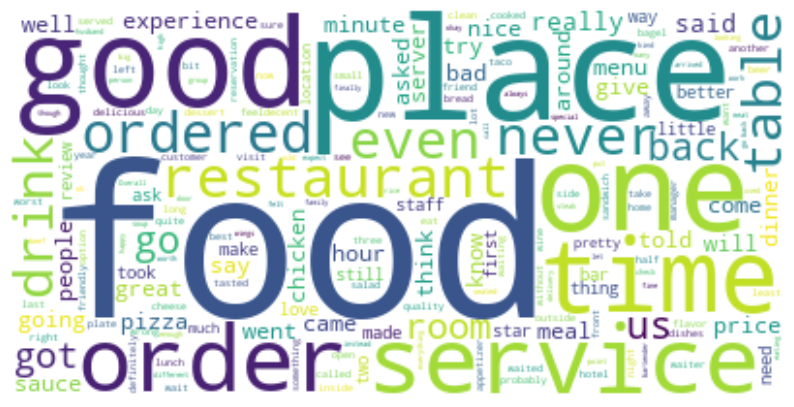

In [ ]:
# Negative WordCloud
neg_lis = df_negative.select('text').collect()

neg_lis = ' '.join([neg_lis[i][0] for i in range(len(neg_lis))])

# Generate a word cloud image
wordcloud = WordCloud(background_color="white").generate(neg_lis)

plt.figure(figsize=(10,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

## Text Preprocessing

In [14]:
import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *
from pyspark.ml import Pipeline
from pyspark.ml.feature import Word2Vec, HashingTF

In [16]:
# Initialize SparkNLP components
document_assembler = DocumentAssembler() \
    .setInputCol("text") \
    .setOutputCol("document")

languageDetector = LanguageDetectorDL.pretrained() \
    .setInputCols("document") \
    .setOutputCol("language")

# Create a SparkNLP pipeline
pipeline1 = Pipeline(stages=[document_assembler, languageDetector])

ld_wiki_tatoeba_cnn_21 download started this may take some time.
Approximate size to download 7.1 MB
[OK!]


### Detect review languages

In [17]:
df_lang = pipeline1.fit(df).transform(df)
df_lang = df_lang.select("text", "label", "weight", "language.result")

In [16]:
df_lang.show(10)

+--------------------+-----+------+
|                text|label|result|
+--------------------+-----+------+
|I've been a loyal...|    0|  [en]|
|Checked this plac...|    0|  [en]|
|Is this place clo...|    0|  [en]|
|We are so excited...|    1|  [en]|
|I moved to Nashvi...|    1|  [en]|
|If you like 90% b...|    1|  [en]|
|I saw this place ...|    0|  [en]|
|It's Mexican fast...|    1|  [en]|
|Farotto's - you d...|    0|  [en]|
|I love this place...|    1|  [en]|
+--------------------+-----+------+
only showing top 10 rows



In [ ]:
df_lang.printSchema()

root
 |-- text: string (nullable = true)
 |-- label: integer (nullable = false)
 |-- result: array (nullable = true)
 |    |-- element: string (containsNull = true)



In [ ]:
df3 = df_lang.groupBy('result').count().orderBy('count', ascending = [0])

In [ ]:
df3.show()

+------+-----+
|result|count|
+------+-----+
|  [en]|  385|
+------+-----+



In [ ]:
pdf3 = df3.toPandas()

<AxesSubplot:ylabel='result'>

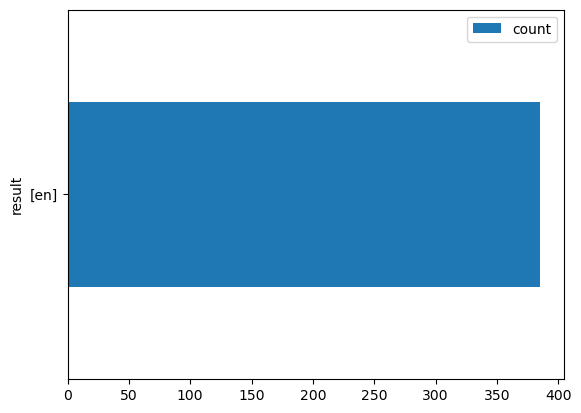

In [ ]:
pdf3.plot(kind = 'barh', x = 'result', y = 'count')

In [18]:
from pyspark.sql.functions import array_contains

# Only keep the reviews written in English for future analysis
df_lang = df_lang.filter(array_contains(col("result"), "en"))

In [18]:
df_lang.show(5)

+--------------------+-----+------+
|                text|label|result|
+--------------------+-----+------+
|I've been a loyal...|    0|  [en]|
|Checked this plac...|    0|  [en]|
|Is this place clo...|    0|  [en]|
|We are so excited...|    1|  [en]|
|I moved to Nashvi...|    1|  [en]|
+--------------------+-----+------+
only showing top 5 rows



In [19]:
df_lang = df_lang.drop('result')

### Produce a final processed output

In [20]:
tokenizer = Tokenizer() \
    .setInputCols(["document"]) \
    .setOutputCol("token")

normalizer = Normalizer() \
    .setInputCols(["token"]) \
    .setOutputCol("normalized") \
    .setLowercase(True) \
    .setCleanupPatterns(["""[^\w\d\s]"""])

lemmatizer = LemmatizerModel.pretrained() \
    .setInputCols(["normalized"]) \
    .setOutputCol("lemmatized")

finisher = Finisher() \
    .setInputCols(['lemmatized']) \
    .setOutputCols(["finished"])

word2vec = Word2Vec(vectorSize=100) \
    .setInputCol("finished") \
    .setOutputCol("features")

hashingTF = HashingTF() \
    .setInputCol("finished") \
    .setOutputCol("features")

pipeline2 = Pipeline(stages=[document_assembler, tokenizer, normalizer, lemmatizer, finisher, word2vec])
pipeline3 = Pipeline(stages=[document_assembler, tokenizer, normalizer, lemmatizer, finisher, hashingTF])

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[ | ]lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
Download done! Loading the resource.
[ / ]

[OK!]


In [ ]:
# Use Word2Vec
pipeline_model = pipeline2.fit(df_lang)
encodedData = pipeline_model.transform(df_lang)

In [21]:
# Use Hashing-TF
pipeline_model2 = pipeline3.fit(df_lang)
encodedData2 = pipeline_model2.transform(df_lang)

In [22]:
#encodedData = encodedData.select('text', 'label', 'weight', 'features')
encodedData2 = encodedData2.select('text', 'label', 'weight', 'features')

In [24]:
#encodedData.cache()
encodedData2.cache()

DataFrame[text: string, label: int, weight: double, features: vector]

## Classification Models

In [23]:
#spark ML imports
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, LinearSVC, GBTClassifier, RandomForestClassificationModel

from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

In [ ]:
#split data into train and test
train_df, test_df = encodedData.randomSplit([.8,.2],seed = 16)
train_df.show(5)

In [24]:
train_df2, test_df2 = encodedData2.randomSplit([.8,.2],seed = 16)
#train_df2.show(5)

### Random Forest Classifier

In [30]:
rf = RandomForestClassifier()\
    .setLabelCol('label')\
    .setFeaturesCol('features')\
    .setWeightCol('weight')

In [31]:
rfModel = rf.fit(train_df)
rf_pred = rfModel.transform(test_df)
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

print("accuracy:", round(evaluator.evaluate(rf_pred, {evaluator.metricName: "accuracy"}), 2))
print("f1:", round(evaluator.evaluate(rf_pred, {evaluator.metricName: "f1"}), 2))

accuracy: 0.67
f1: 0.67


In [32]:
rfModel2 = rf.fit(train_df2)
rf_pred2 = rfModel2.transform(test_df2)
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

print("accuracy:", round(evaluator.evaluate(rf_pred2, {evaluator.metricName: "accuracy"}), 2))
print("f1:", round(evaluator.evaluate(rf_pred2, {evaluator.metricName: "f1"}), 2))

23/08/16 16:16:50 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/08/16 16:16:55 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1032.8 KiB
23/08/16 16:16:56 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 3.5 MiB
23/08/16 16:16:59 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 3.5 MiB
23/08/16 16:17:00 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 3.5 MiB
23/08/16 16:17:02 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 3.5 MiB
23/08/16 16:17:04 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 3.5 MiB


accuracy: 0.68
f1: 0.67


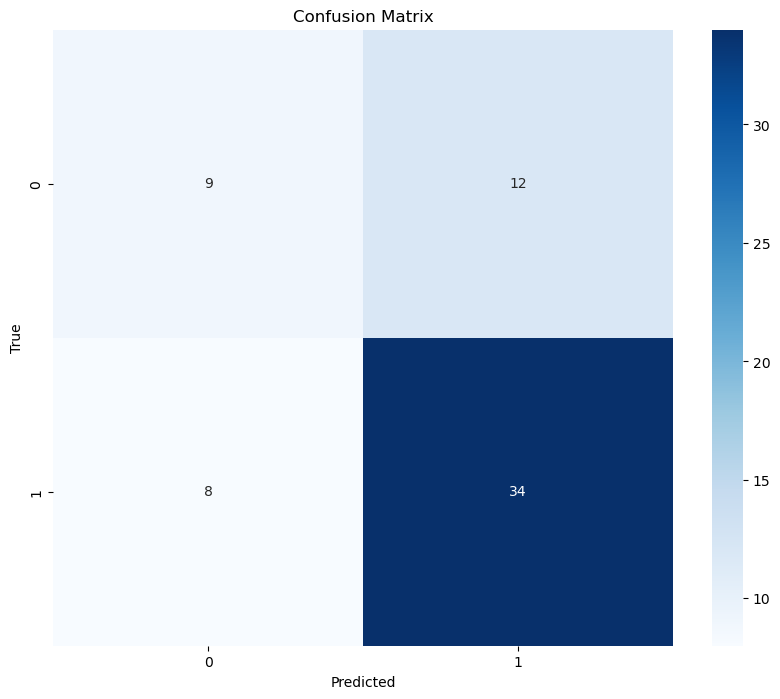

In [33]:
# Calculate the confusion matrix
confusion_matrix = rf_pred2.groupBy("label", "prediction").count().toPandas()

# Convert the confusion matrix to a matrix format for plotting
num_classes = len(confusion_matrix['label'].unique())
conf_matrix = np.zeros((num_classes, num_classes), dtype=int)

for _, row in confusion_matrix.iterrows():
    true_label = int(row['label'])
    predicted_label = int(row['prediction'])
    count = row['count']
    conf_matrix[true_label][predicted_label] = count

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=[f"{i}" for i in range(num_classes)],
            yticklabels=[f"{i}" for i in range(num_classes)])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")

plt.show()

### LinearSVC